In [1]:
import json

eval_PATH = 'data/test.json'
train_PATH = 'data/train.json'
val_PATH = 'data/validation.json'
pred_PATH = 'data_pred/main-pred-2enc-2dec.json'


e_trim = 100000
t_trim = 100000
v_trim = 100000

with open(eval_PATH, 'r') as f:
  eval_data = json.load(f)[:e_trim]
with open(train_PATH, 'r') as f:
  train_data = json.load(f)[:t_trim]
with open(val_PATH, 'r') as f:
  val_data = json.load(f)[:v_trim]
with open(pred_PATH, 'r') as f:
  pred_data = json.load(f)

In [2]:
from utils.transforms import construct_token_transform
token_transform = construct_token_transform()

/Users/batuel/Documents/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Decoding Methods
pred_data.keys()

dict_keys(['Greedy', 'Temperature 0.5', 'Temperature 1 (Unbiased)'])

In [5]:
eval_articles = [example['article'] for example in eval_data]
eval_summaries = [example['summary'] for example in eval_data]

pred_articles_grdy = [example['article'] for example in pred_data['Greedy']]
pred_summaries_grdy = [example['summary'] for example in pred_data['Greedy']]
pred_articles_unb = [example['article'] for example in pred_data['Temperature 1 (Unbiased)']]
pred_summaries_unb = [example['summary'] for example in pred_data['Temperature 1 (Unbiased)']]
pred_articles_temp = [example['article'] for example in pred_data['Temperature 0.5']]
pred_summaries_temp = [example['summary'] for example in pred_data['Temperature 0.5']]
# pred_articles_bs = [example['article'] for example in pred_data['Beam Search']]
# pred_summaries_bs = [example['summary'] for example in pred_data['Beam Search']]
# pred_articles_mbr = [example['article'] for example in pred_data['MBR']]
# pred_summaries_mbr = [example['summary'] for example in pred_data['MBR']]
# pred_articles_rand = [example['article'] for example in pred_data['Random (Uniform)']]
# pred_summaries_rand = [example['summary'] for example in pred_data['Random (Uniform)']]

In [6]:
tok_eval_articles = [token_transform(example) for example in eval_articles]
tok_eval_summaries = [token_transform(example) for example in eval_summaries]
tok_pred_articles_grdy = [token_transform(example) for example in pred_articles_grdy]
tok_pred_summaries_grdy = [token_transform(example) for example in pred_summaries_grdy]
tok_pred_articles_unb = [token_transform(example) for example in pred_articles_unb]
tok_pred_summaries_unb = [token_transform(example) for example in pred_summaries_unb]
tok_pred_articles_temp = [token_transform(example) for example in pred_articles_temp]
tok_pred_summaries_temp = [token_transform(example) for example in pred_summaries_temp]
# tok_pred_articles_bs = [token_transform(example) for example in pred_articles_bs]
# tok_pred_summaries_bs = [token_transform(example) for example in pred_summaries_bs]
# tok_pred_articles_mbr = [token_transform(example) for example in pred_articles_mbr]
# tok_pred_summaries_mbr = [token_transform(example) for example in pred_summaries_mbr]

In [7]:
# eval_art_len = [len(art) for art in tok_eval_articles]
# scores_grdy_mod = [scores_grdy[i]['rouge-1']['f'] for i in range(10)]
# scores_unb_mod = [scores_unb[i]['rouge-1']['f'] for i in range(10)]
# scores_temp_mod = [scores_temp[i]['rouge-1']['f'] for i in range(10)]
# scores_bs_mod = [scores_bs[i]['rouge-1']['f'] for i in range(10)]
# scores_mbr_mod = [scores_mbr[i]['rouge-1']['f'] for i in range(10)]

# plt.scatter(eval_art_len, scores_grdy_mod)
# plt.scatter(eval_art_len, scores_bs_mod)

# plt.scatter(eval_art_len, scores_unb_mod)
# plt.scatter(eval_art_len, scores_temp_mod)
# plt.scatter(eval_art_len, scores_mbr_mod)

In [8]:
import numpy as np
import pandas as pd
import tqdm
from rouge_metric import PyRouge
rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True, rouge_s=True, rouge_su=True)


def pairwise_eval(rouge, pred_summary, eval_summary):
    scores = rouge.evaluate( [pred_summary], [[eval_summary]])
    #df = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
    return scores

scores_grdy = []
scores_unb = []
scores_temp = []
scores_bs = []
scores_mbr = []


for sum_i in tqdm.tqdm(range(len(eval_summaries)), desc=''):
    scores_grdy.append(pairwise_eval(rouge , pred_summaries_grdy[sum_i] , eval_summaries[sum_i] ))
    scores_unb.append(pairwise_eval(rouge , pred_summaries_unb[sum_i] , eval_summaries[sum_i] ))
    scores_temp.append(pairwise_eval(rouge , pred_summaries_temp[sum_i] , eval_summaries[sum_i] ))
    # scores_bs.append(pairwise_eval(rouge , pred_summaries_bs[sum_i] , eval_summaries[sum_i] ))
    # scores_mbr.append(pairwise_eval(rouge , pred_summaries_mbr[sum_i] , eval_summaries[sum_i] ))

rouge_keys = list(scores_grdy[0].keys())
rouge_dict_grdy = {}
rouge_dict_unb = {}
rouge_dict_temp = {}
rouge_dict_bs = {}
rouge_dict_mbr = {}

for key in rouge_keys:
    rouge_dict_grdy[key] = {}
    for rpf in  ['r']:
        rouge_dict_grdy[key] = [score[key][rpf] for score in scores_grdy]
        rouge_dict_unb[key] = [score[key][rpf] for score in scores_unb]
        rouge_dict_temp[key] = [score[key][rpf] for score in scores_temp]
        # rouge_dict_bs[key] = [score[key][rpf] for score in scores_bs]
        # rouge_dict_mbr[key] = [score[key][rpf] for score in scores_mbr]

100%|██████████| 1000/1000 [00:10<00:00, 91.93it/s]


In [9]:
rouge_dict_unb.keys()

dict_keys(['rouge-1', 'rouge-2', 'rouge-4', 'rouge-l', 'rouge-w-1.2', 'rouge-s*', 'rouge-su*'])

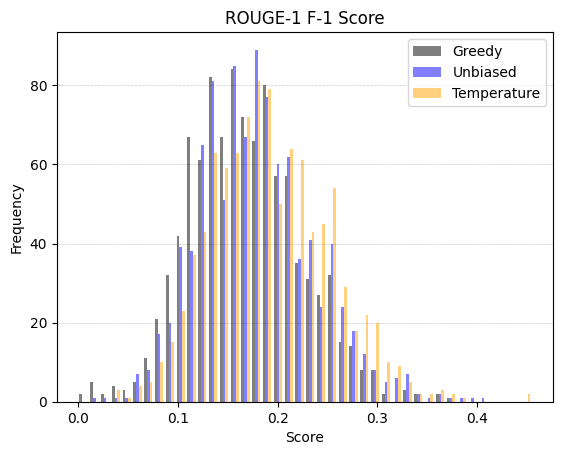

In [10]:
import matplotlib.pyplot as plt

rouge_metric = 'rouge-1'
d = [rouge_dict_grdy[rouge_metric], rouge_dict_unb[rouge_metric], rouge_dict_temp[rouge_metric]]#, rouge_dict_bs[rouge_metric], rouge_dict_mbr[rouge_metric]]
colors = ['black', 'blue', 'orange'] #,'green', 'purple']
labels = ['Greedy','Unbiased','Temperature'] #, 'bs', 'mbr']

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=d, bins='auto', color=colors, alpha=0.5, rwidth=0.75, label=labels)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('ROUGE-1 F-1 Score')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 2)
plt.legend()
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5, axis='y', alpha=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


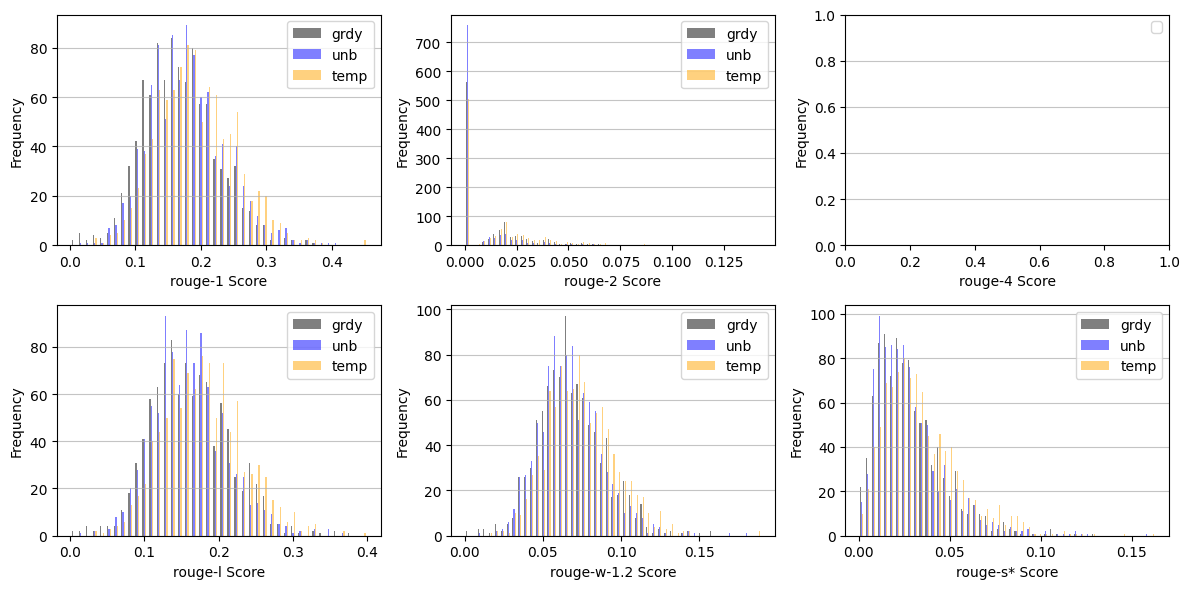

In [11]:
import matplotlib.pyplot as plt
import numpy as np

data=np.random.random((4,10))
xaxes = ['x1','x2','x3','x4']
yaxes = ['y1','y2','y3','y4']
titles = ['t1','t2','t3','t4'] 

colors = ['black', 'blue', 'orange']#,'green', 'purple']
labels = ['grdy','unb','temp']#, 'bs', 'mbr']

f,a = plt.subplots(2,3,figsize=(12, 6))
a = a.ravel()
for idx,ax in enumerate(a):
    rouge_metric = list(rouge_dict_unb.keys())[idx]
    d = [rouge_dict_grdy[rouge_metric], rouge_dict_unb[rouge_metric], rouge_dict_temp[rouge_metric]]#, rouge_dict_bs[rouge_metric], rouge_dict_mbr[rouge_metric]]
    if idx != 2:
        n, bins, patches = ax.hist(x=d, bins='auto', color=colors, alpha=0.5, rwidth=0.55, label=labels)
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel(f'{rouge_metric} Score')
    ax.set_ylabel('Frequency')
    # ax.set_title('Histogram')
    # plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    # plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 2)
    ax.legend()
plt.tight_layout()

In [12]:
d = {}

In [13]:
from evaluation.rouge_evaluator import RougeEvaluator
import pandas as pd

evaluator = RougeEvaluator()
scores = evaluator.batch_score(pred_summaries_unb, eval_summaries)
df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
d['Unbiased'] = df_scores

In [15]:
# from evaluation.rouge_evaluator import RougeEvaluator
# import pandas as pd

# evaluator = RougeEvaluator()
# scores = evaluator.batch_score(pred_summaries_rand, eval_summaries)
# df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
# d['Random (Uniform)'] = df_scores

In [16]:
evaluator = RougeEvaluator()
scores = evaluator.batch_score(pred_summaries_grdy, eval_summaries)
df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
d['Greedy'] = df_scores

In [17]:
evaluator = RougeEvaluator()
scores = evaluator.batch_score(pred_summaries_temp, eval_summaries)
df_scores = pd.DataFrame(scores).transpose().rename(columns={"r" : "Recall" ,"p" : "Precision" ,"f" : "F1-score" })
d['Temperature'] = df_scores

In [18]:
pd.concat(d, axis = 0).round(3)

Recall  Precision  F1-score
Unbiased    rouge-1   0.179      0.185     0.182
            rouge-2   0.006      0.006     0.006
            rouge-4   0.000      0.000     0.000
            rouge-l   0.161      0.166     0.163
Greedy      rouge-1   0.168      0.207     0.186
            rouge-2   0.012      0.015     0.013
            rouge-4   0.000      0.000     0.000
            rouge-l   0.162      0.199     0.179
Temperature rouge-1   0.192      0.232     0.210
            rouge-2   0.015      0.018     0.016
            rouge-4   0.000      0.000     0.000
            rouge-l   0.179      0.215     0.195